In [16]:
import pandas as pd
import pickle
import os


from config import BASE_DIR
print(os.getcwd()+' -> ',end=' ')
os.chdir(BASE_DIR)
print(BASE_DIR)

from scripts.indicators import find_pivots,donchian

C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www ->  C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [17]:
#klines_file =  './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/2d01/Lateral_BTCUSDT_2d01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
klines_file = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/0m01/Bajista_BTCUSDT_0m01_2021-04-12_2021-07-12.DataFrame'


with open(klines_file, 'rb') as file:
    df = pickle.load(file)

start_date = klines_file.split('/')[4].split('_')[3] #Extrae la fecha de inicio
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
start_date = start_date.replace(hour=0, minute=0, second=0)


In [18]:
class Order:
    id = 0
    datetime = None
    side = ''
    qty = 0
    price = 0

    def __init__(self,id,datetime,side,qty,price):
        self.datetime = datetime
        self.side = side
        self.qty = qty
        self.price = price
        self.id = id
    
    def __repr__(self):
        return '<' + str(self) + '>'

    def __str__(self):
        params = f'{self.datetime} #{self.id} {self.side}\t{self.qty:.8f}\t{self.price:.8f}'
        return f'{self.__class__.__name__} {params}'

class Backtester:

    data = pd.DataFrame
    start_at = 0
    cash = 0
    qty = 0
    pos = False
    orders = {}
    row = None
    signal = 'NEUTRO'
    order_id = 0

    def __init__(self,cash,data,start_at):
        self.start_at = start_at
        self.data = data
        self.cash = cash
       
    def signal(self):
        pass

    def next(self):
        pass
        
    def run(self):
        #Aplica las señales de compra venta a la totalidad del dataframe
        self.signal()

        #Limita el dataframe a la fecha de inicio real
        self.data = self.data[self.data['datetime']>=self.start_at]
        self.data = self.data.reset_index(drop=True)
        qty_to_hold = self.cash/float(self.data['close'].iloc[0])
        self.data['hold'] = self.data['close'] * qty_to_hold
        self.data['equity'] = self.data.apply(self._next, axis=1)
        print(self.data['datetime'].loc[0])

    def _next(self,row):
        self.row = row
        self.price = row['open']
        self.next()
        self.signal = row['signal']
        return (self.cash + self.qty*self.price)
        
    def buy(self,qty):
        if self.cash >= qty*self.price and qty*self.price>=10: #Compra solo si hay cash y si el cash a comprar es > 10 USD
            self.order_id += 1
            qty = round(qty,8)
            order = Order(self.order_id,self.row['datetime'],'BUY',qty,self.price)
            self.cash -= round(qty*self.price,2)
            self.qty += qty
            self.pos = True
            self.orders[self.order_id] = order
            return order
        return 0

    def sell(self,qty):
        if self.qty >= qty and qty*self.price>=10: #Vende solo si hay qty y si el cash a vender es > 10 USD
            self.order_id += 1
            self.qty -= qty
            self.cash += round(qty*self.price,2) 
            order = Order(self.order_id,self.row['datetime'],'SELL',-qty,self.price)
            if round(self.qty,8) == 0:
                self.pos = False
            self.orders[self.order_id] = order 
            return order
        return 0

    def close(self):
        return self.sell(self.qty)


2021-01-01 00:00:00


<Axes: >

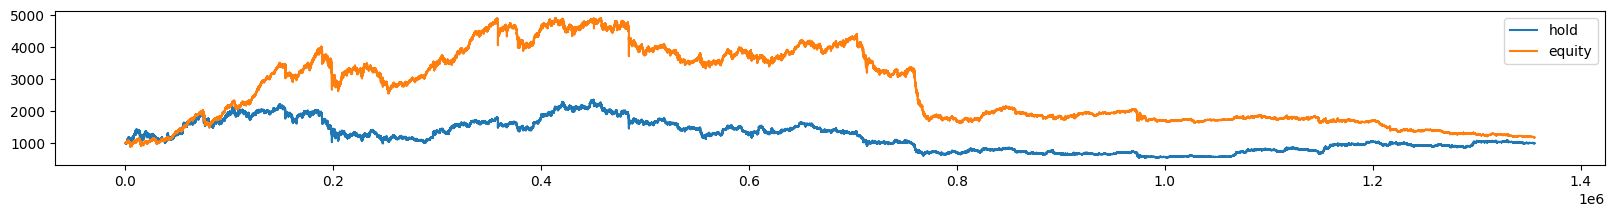

In [19]:

# Aplicar la función signal
class Bot(Backtester):
    """
    def signal(self):
        
        self.data['ma'] = self.data['close'].rolling(window=21).mean()
        
        self.data['compra'] = (self.data['close'] < self.data['ma']) 
        self.data['venta']  = (self.data['close'] > self.data['ma']) 

        self.data['signal'] = np.where(self.data['compra'], 'COMPRA', 'NEUTRO')
        self.data['signal'] = np.where(self.data['venta'], 'VENTA',self.data['signal'])

        self.data.drop('ma', axis=1, inplace=True)
        self.data.drop('compra', axis=1, inplace=True)
        self.data.drop('venta', axis=1, inplace=True)
    
    def next(self):
        if self.signal == 'COMPRA':
            if self.cash > 10 and not self.pos: 
                qty = self.cash/self.price
                self.buy(qty)
                 
        if self.signal == 'VENTA':
            if self.qty >= 0 and self.pos: 
                self.close()   
    """
    pos = {}

    def get_pos(self):
        pos = {}
        pos['base_qty'] = 0
        pos['quote_qty'] = 0
        pos['avg_price'] = 0
        for i in self.pos:
            order = self.pos[i]
            pos['base_qty'] += order.qty
            pos['quote_qty'] += round(order.qty*order.price)
        pos['avg_price'] = round(pos['quote_qty']/pos['base_qty'],10)
        return pos
    
    def signal(self):
        self.data['signal'] = 'NEUTRO'
    
    def next(self):
        pass

bt = Bot(cash = 1000, data = df, start_at = start_date)
bt.run()
bt.data[['hold','equity']].plot(figsize=(20,2))




In [20]:
bt.orders





{1: <Order 2021-01-01 00:02:00 #1 BUY	0.03421928	29223.29000000>,
 2: <Order 2021-01-01 00:06:00 #2 SELL	-0.03421928	29251.73000000>,
 3: <Order 2021-01-01 00:19:00 #3 BUY	0.03423671	29236.75000000>,
 4: <Order 2021-01-01 00:33:00 #4 SELL	-0.03423671	29238.51000000>,
 5: <Order 2021-01-01 00:35:00 #5 BUY	0.03426320	29215.89000000>,
 6: <Order 2021-01-01 00:36:00 #6 SELL	-0.03426320	29237.89000000>,
 7: <Order 2021-01-01 00:51:00 #7 BUY	0.03425231	29247.08000000>,
 8: <Order 2021-01-01 00:54:00 #8 SELL	-0.03425231	29295.38000000>,
 9: <Order 2021-01-01 01:13:00 #9 BUY	0.03425570	29292.35000000>,
 10: <Order 2021-01-01 01:16:00 #10 SELL	-0.03425570	29339.22000000>,
 11: <Order 2021-01-01 01:30:00 #11 BUY	0.03426334	29332.81000000>,
 12: <Order 2021-01-01 01:31:00 #12 SELL	-0.03426334	29349.43000000>,
 13: <Order 2021-01-01 01:32:00 #13 BUY	0.03431539	29304.93000000>,
 14: <Order 2021-01-01 01:51:00 #14 SELL	-0.03431539	29218.80000000>,
 15: <Order 2021-01-01 02:03:00 #15 BUY	0.03437347	2

In [21]:
from datetime import datetime as dt
print(dt.now())
agg_funcs = {
                "open": "first",
                "high": "max",
                "low": "min",
                "close": "last",
                "volume": "sum",
            }   
new_df = df[['datetime','open','high','low','close','volume']].resample('1D', on="datetime").agg(agg_funcs).reset_index()
#print(dt.now())
ohlc = new_df[['datetime','open','high','low','close','volume']].rename(columns={'datetime': 'dt', 'open': 'o', 'high': 'h', 'low': 'l', 'close': 'c', 'volume': 'v'}).to_dict(orient='records')
#print(dt.now())
#print(df.tail())
#ohlc

2023-12-26 09:55:17.536311


In [22]:
new_df = df[['datetime','signal','low','high']]
sB = df[df['signal']=='COMPRA'][['datetime','low']].rename(columns={'low':'sB'}).to_dict(orient='records')
#new_df['sS'] = new_df[new_df['signal']=='VENTA']['high']
sS= df[df['signal']=='VENTA'][['datetime','high']].rename(columns={'high':'sS'}).to_dict(orient='records')
events = sB+sS
events

[{'datetime': Timestamp('2020-12-31 00:35:00'), 'sB': 28906.76},
 {'datetime': Timestamp('2020-12-31 00:36:00'), 'sB': 28889.0},
 {'datetime': Timestamp('2020-12-31 00:37:00'), 'sB': 28887.87},
 {'datetime': Timestamp('2020-12-31 00:38:00'), 'sB': 28900.99},
 {'datetime': Timestamp('2020-12-31 00:39:00'), 'sB': 28887.87},
 {'datetime': Timestamp('2020-12-31 00:40:00'), 'sB': 28881.7},
 {'datetime': Timestamp('2020-12-31 00:41:00'), 'sB': 28885.0},
 {'datetime': Timestamp('2020-12-31 00:42:00'), 'sB': 28864.41},
 {'datetime': Timestamp('2020-12-31 00:43:00'), 'sB': 28877.31},
 {'datetime': Timestamp('2020-12-31 00:44:00'), 'sB': 28890.95},
 {'datetime': Timestamp('2020-12-31 01:02:00'), 'sB': 28985.0},
 {'datetime': Timestamp('2020-12-31 01:03:00'), 'sB': 28969.3},
 {'datetime': Timestamp('2020-12-31 01:04:00'), 'sB': 28961.93},
 {'datetime': Timestamp('2020-12-31 01:05:00'), 'sB': 28944.75},
 {'datetime': Timestamp('2020-12-31 01:06:00'), 'sB': 28985.53},
 {'datetime': Timestamp('2020-

In [23]:
trades = {}
orders = {}
order_id = 0

order_id +=1
order = Order(order_id,dt.now(),'BUY',1,30000)
orders[order.id] = order
order_id +=1
order = Order(order_id,dt.now(),'BUY',1,29000)
orders[order.id] = order
order_id +=1
order = Order(order_id,dt.now(),'SELL',1,31000)
orders[order.id] = order

print(orders)
print(trades)

order = orders.pop(1)
trades[order.id] = order
order = orders.pop(2)
trades[order.id] = order

print(orders)
print(trades)


{1: <Order 2023-12-26 09:55:20.975243 #1 BUY	1.00000000	30000.00000000>, 2: <Order 2023-12-26 09:55:20.975243 #2 BUY	1.00000000	29000.00000000>, 3: <Order 2023-12-26 09:55:20.975243 #3 SELL	1.00000000	31000.00000000>}
{}
{3: <Order 2023-12-26 09:55:20.975243 #3 SELL	1.00000000	31000.00000000>}
{1: <Order 2023-12-26 09:55:20.975243 #1 BUY	1.00000000	30000.00000000>, 2: <Order 2023-12-26 09:55:20.975243 #2 BUY	1.00000000	29000.00000000>}
